# Домашняя работа № 3

### 1. Вывести распределение (количество) клиентов по сферам деятельности, отсортировав результат по убыванию количества

In [ ]:
select job_industry_category, count(*) from customer
group by job_industry_category
order by count(*) desc;

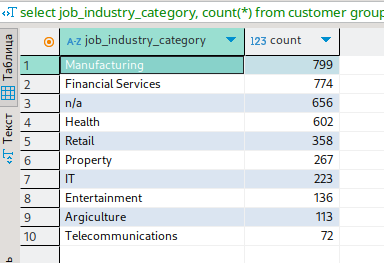

### 2. Найти сумму транзакций за каждый месяц по сферам деятельности, отсортировав по месяцам и по сфере деятельности.

In [ ]:
select date_part('month', t.transaction_date::date) as month, c.job_industry_category, sum(t.list_price) from "transaction" t
inner join customer c on c.customer_id = t.customer_id
group by date_part('month', t.transaction_date::date), c.job_industry_category
order by date_part('month', t.transaction_date::date), c.job_industry_category;

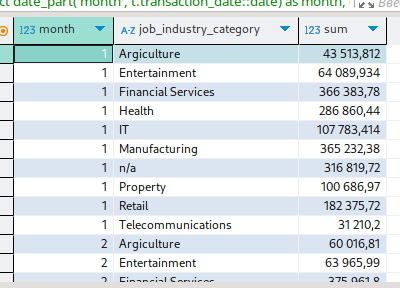

### 3. Вывести количество онлайн-заказов для всех брендов в рамках подтвержденных заказов клиентов из сферы IT.

In [ ]:
select t.brand, count(*) from "transaction" t
inner join customer c on c.customer_id = t.customer_id
where c.job_industry_category = 'IT' and t.online_order = 'True' and order_status = 'Approved'
group by t.brand;

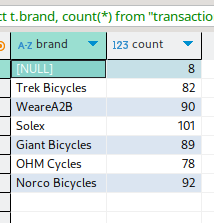

### 4. Найти по всем клиентам сумму всех транзакций (list_price), максимум, минимум и количество транзакций, отсортировав результат по убыванию суммы транзакций и количества ~~клиентов~~ транзакций. Выполните двумя способами: используя только group by и используя только оконные функции. Сравните результат. 

4.1 Используя group by

In [ ]:
select
t.customer_id,
sum(t.list_price) sum_price,
max(t.list_price) as max_price,
min(t.list_price) as min_price,
count(t.transaction_id) as tr_count
from "transaction" t
group by t.customer_id
order by sum_price desc, tr_count desc;

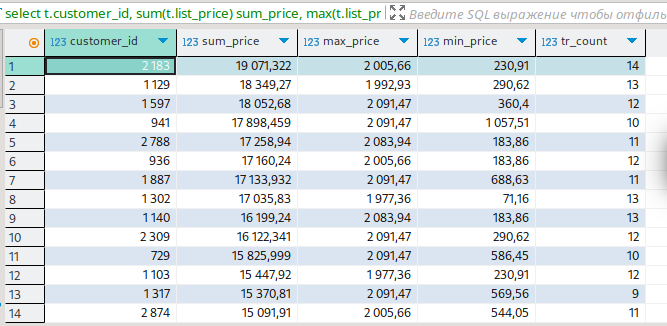

4.2 Используя оконные функции

In [ ]:
select distinct 
t.customer_id,
sum(t.list_price) over (partition by customer_id) as sum_price,
max(t.list_price) over (partition by customer_id) as max_price,
min(t.list_price) over (partition by customer_id) as min_price,
count(t.transaction_id) over (partition by customer_id) as tr_count
from "transaction" t
order by sum_price desc, tr_count desc;

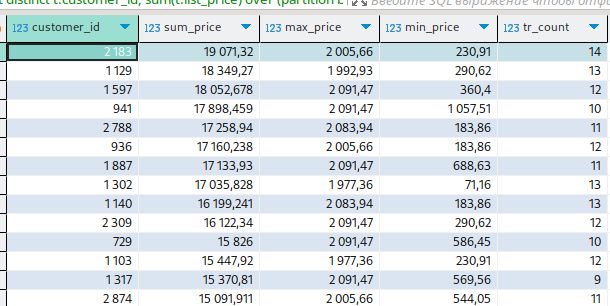

### 5. Найти имена и фамилии клиентов с минимальной/максимальной суммой транзакций за весь период (сумма транзакций не может быть null). Напишите отдельные запросы для минимальной и максимальной суммы.

Для минимальной суммы

In [ ]:
select c.last_name, c.first_name, min_sum.sum_price
from customer c 
inner join (
	select customer_id, sum(list_price) as sum_price from "transaction" t
	group by customer_id
	order by sum_price asc
	limit 1
) min_sum on min_sum.customer_id = c.customer_id;

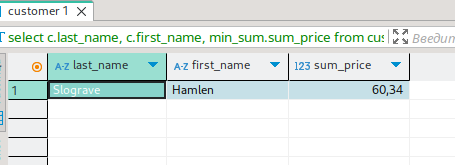

Для максимальной суммы

In [ ]:
select c.last_name, c.first_name, max_sum.sum_price
from customer c 
inner join (
	select customer_id, sum(list_price) as sum_price from "transaction" t
	group by customer_id
	order by sum_price desc
	limit 1
) max_sum on max_sum.customer_id = c.customer_id;

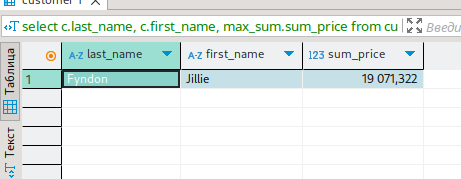

### 6. Вывести только самые первые транзакции клиентов. Решить с помощью оконных функций. 

In [ ]:
with numbered_transaction as (
	select distinct 
	*,
	row_number() over (partition by t.customer_id order by transaction_date::date) as tr_number
	from "transaction" t
)
select * from numbered_transaction
where tr_number = 1;

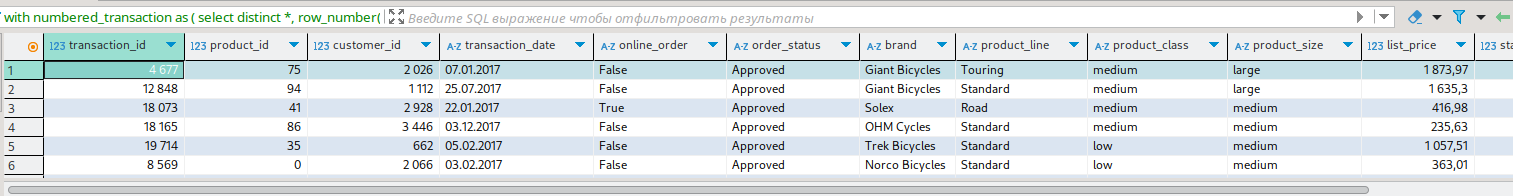

### 7. Вывести имена, фамилии и профессии клиентов, между транзакциями которых был максимальный интервал (интервал вычисляется в днях)

In [ ]:
with transaction_with_max_interval as ( 
	select
	transaction_id,
	customer_id,
	coalesce (lead(transaction_date::date) over (partition by t.customer_id order by transaction_date::date) - transaction_date::date, -1) as day_diff
	from "transaction" t
	order by day_diff desc
	limit 1
)
select c.first_name, c.last_name, c.job_title, twmi.day_diff
from customer c
inner join transaction_with_max_interval twmi
on c.customer_id = twmi.customer_id

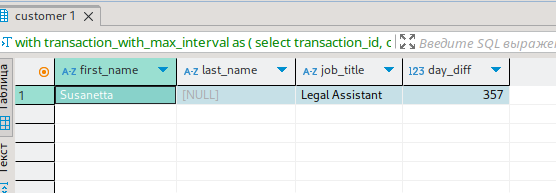